In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from birdclef.spark import get_spark
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
from pacmap import PaCMAP
import numpy as np
from pathlib import Path

In [31]:
@F.udf("array<float>")
def mean_udf(arr):
    return np.mean(arr, axis=0).tolist()


def read_embeddings(spark, path):
    df = spark.read.parquet(path)
    return df.select(
        *df.columns[:3],
        F.array(*df.columns[3:]).alias("embeddings"),
    ).orderBy("file", "start_time")


def average_embeddings(df):
    return (
        df.groupBy("file")
        .agg(mean_udf(F.collect_list("embeddings")).alias("embeddings"))
        .orderBy("file")
    )


def plot_embeddings_pdf(pdf, title="embedding plot", col="embeddings", color=None):
    X = np.stack(pdf[col].values)
    reducer = PaCMAP(n_components=2)
    g = reducer.fit_transform(X)
    kwargs = {}
    if color is not None:
        kwargs["c"] = color
    plt.scatter(g[:, 0], g[:, 1], s=1, alpha=0.5, **kwargs)
    plt.title(title)
    plt.show()


def plot_embeddings(df, *args, **kwargs):
    plot_embeddings_pdf(df.toPandas(), *args, **kwargs)

In [22]:
root = Path("~/shared/birdclef/2025").expanduser()
spark = get_spark(cores=8, memory="20g")

25/04/26 15:17:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


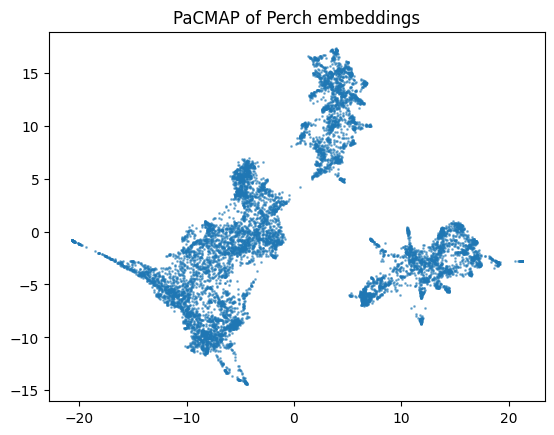

In [23]:
perch = read_embeddings(spark, f"{root}/infer-soundscape/Perch/parts/embed")
avg_perch = average_embeddings(perch).cache()
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings")

Let's figure what this looks like when we aren't doing the averaging over the entire dataset. What does that look like?

When we do clustering, we can look at the clusters between the average of the soundscape (which might require doing some filtering over the set of sounds) and the individual sound snippets. These two representations _are_ different.

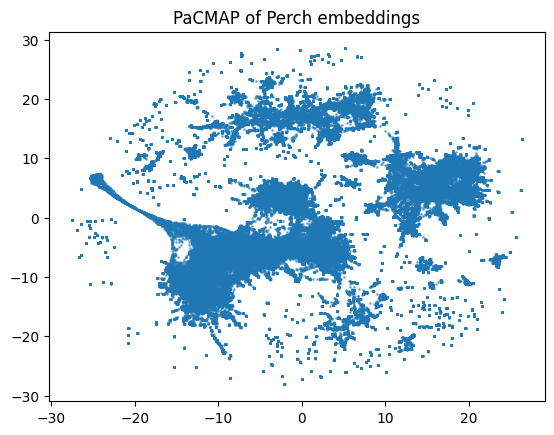

In [10]:
plot_embeddings(perch, "PaCMAP of Perch embeddings")

Let's run hdbscan on the entire soundscape dataset to figure out what the clusters look like. We should remove everything that is noise, and see how many of the samples are still left.

In [24]:
reducer = PaCMAP(n_components=20)
X = np.stack(perch.toPandas()["embeddings"].values)
g = reducer.fit_transform(X)

Note: `n_components != 2` have not been thoroughly tested.


In [25]:
import fast_hdbscan

clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(g)

In [29]:
clusterdf = perch.select("file", "start_time").toPandas()
clusterdf["cluster"] = cluster_labels
perch_clusters = perch.join(
    spark.createDataFrame(clusterdf),
    on=["file", "start_time"],
    how="inner",
)
# total number of clusters
display(perch_clusters.select("cluster").distinct().count())
perch_clusters.groupBy("file").agg(F.countDistinct("cluster")).summary().show()
perch_clusters.groupBy("cluster").count().orderBy("count", ascending=False).show(10)

25/04/26 15:36:33 WARN TaskSetManager: Stage 72 contains a task of very large size (2302 KiB). The maximum recommended task size is 1000 KiB.


64

25/04/26 15:36:36 WARN TaskSetManager: Stage 79 contains a task of very large size (2302 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+-----------------------+
|summary|                file|count(DISTINCT cluster)|
+-------+--------------------+-----------------------+
|  count|                9726|                   9726|
|   mean|                NULL|     1.1618342586880526|
| stddev|                NULL|     0.4113146365798108|
|    min|/storage/coda1/p-...|                      1|
|    25%|                NULL|                      1|
|    50%|                NULL|                      1|
|    75%|                NULL|                      1|
|    max|/storage/coda1/p-...|                      4|
+-------+--------------------+-----------------------+



25/04/26 15:36:39 WARN TaskSetManager: Stage 90 contains a task of very large size (2302 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----+
|cluster|count|
+-------+-----+
|      7|61752|
|     -1|23275|
|     15| 2622|
|     10| 1540|
|     57| 1458|
|     48| 1291|
|     29|  927|
|     35|  893|
|     55|  877|
|      3|  848|
+-------+-----+
only showing top 10 rows



25/04/26 15:49:22 WARN TaskSetManager: Stage 103 contains a task of very large size (2302 KiB). The maximum recommended task size is 1000 KiB.


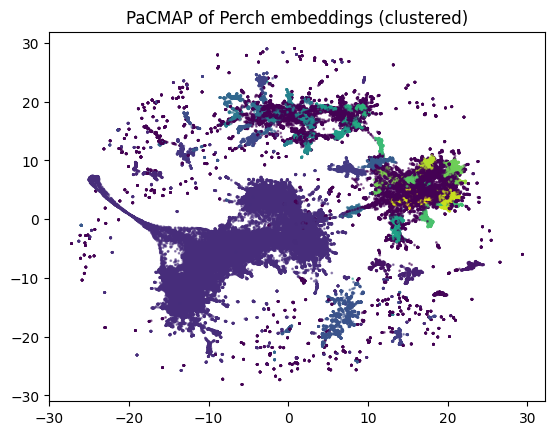

In [35]:
pdf = (
    perch_clusters.orderBy("file", "start_time")
    .select("embeddings", "cluster")
    .toPandas()
)
plot_embeddings_pdf(
    pdf,
    title="PaCMAP of Perch embeddings (clustered)",
    col="embeddings",
    color=pdf["cluster"],
)

25/04/26 15:48:02 WARN TaskSetManager: Stage 98 contains a task of very large size (1845 KiB). The maximum recommended task size is 1000 KiB.


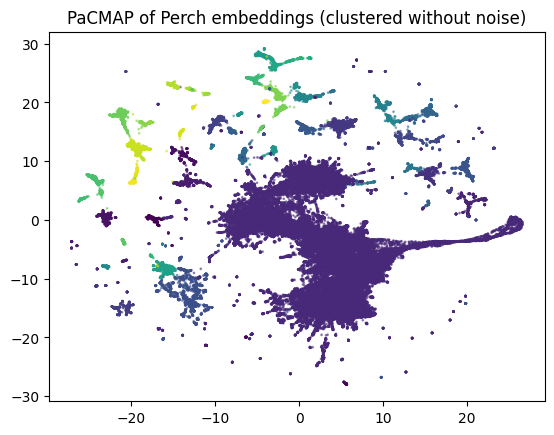

In [34]:
pdf = (
    perch_clusters.where(F.col("cluster") > -1)
    .orderBy("file", "start_time")
    .select("embeddings", "cluster")
    .toPandas()
)
plot_embeddings_pdf(
    pdf,
    title="PaCMAP of Perch embeddings (clustered without noise)",
    col="embeddings",
    color=pdf["cluster"],
)